In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sys,os
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import ListedColormap as lcmap

from time import time
np.set_printoptions(precision=22)

#%precision 22
%matplotlib inline

In [2]:
from evaluate_results import read_results,calc_stats, plt_results,plot_stats_for_topN, find_diff

### How many genes are DE?
* |log2(FC)| >1 and
* adj.pv <0.05

In [3]:
lfc_thr =1.0
adj_pv_thr = 0.05
table = pd.read_csv("GTEx_skin/balanced/results2/All.Rlimma_table.tsv",sep = "\t")
table = table.applymap(lambda x: np.float(x.replace(",",".")))
print("Total genes profiled:",table.shape[0])
d = table.loc[:,["adj.P.Val","logFC"]]
d = d.loc[d["adj.P.Val"]<adj_pv_thr,:]
print("DE based on p-val threhold:")
d_up = d.loc[d["logFC"] >0,:]
d_down = d.loc[d["logFC"] <0,:]
print("\t","upreg:",d_up.shape[0], "downreg:",d_down.shape[0], "total DE:", d_up.shape[0]+d_down.shape[0])
d_up = d.loc[d["logFC"] >=lfc_thr,:]
d_down = d.loc[d["logFC"] <=-lfc_thr,:]
n_DE_genes =  d_up.shape[0]+d_down.shape[0]
print("DE based on p-val and log2FC threholds:")
print("\t","upreg:",d_up.shape[0], "downreg:",d_down.shape[0], "total DE:",n_DE_genes)


Total genes profiled: 21761
DE based on p-val threhold:
	 upreg: 7370 downreg: 8042 total DE: 15412
DE based on p-val and log2FC threholds:
	 upreg: 141 downreg: 147 total DE: 288


### Fig. S1B

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


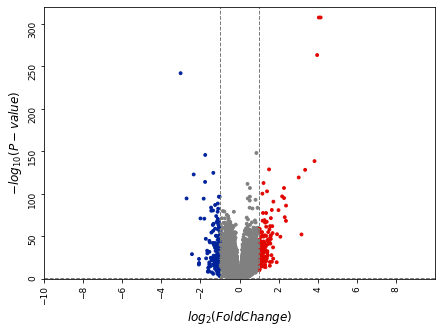

In [4]:
# from: https://reneshbedre.github.io/blog/volcano.html
from bioinfokit import analys, visuz

table["gene_names"] = table.index.values
gnames_to_plot = tuple(table.head(10).index.values)
offset = np.finfo(np.float).tiny
table_to_plot = table.copy()
table_to_plot.loc[table_to_plot["adj.P.Val"]==0,"adj.P.Val"] = offset

visuz.gene_exp.volcano( df=table_to_plot, lfc='logFC', pv='adj.P.Val', #
                       lfc_thr=1, pv_thr=0.05,
                       sign_line=True,
                       #genenames=gnames_to_plot ,geneid="gene_names",gstyle=1,
                       plotlegend=False, legendpos='upper center', 
                       figname = "../../paper_v1/Supplementary/Fig_S1B.Rlimma_volcano",figtype="png",
                       show=True,
                       axlabelfontsize=12,
                       xlm=(-10,10,2),ylm = (0,320,50),
                       color=("#E10600FF", "grey","#00239CFF" ),dim=(7,5))

In [5]:
root_dir = "GTEx_skin//"
dfs = {}
workdir = root_dir + "mild_imbalance/results2/"
df = read_results(workdir)
dfs["Mild Imbalance"]  =df
workdir = root_dir + "balanced/results2/"
df = read_results(workdir)
dfs["Balance"]  =df
workdir = root_dir + "strong_imbalance/results2/"
df = read_results(workdir)
dfs["Strong Imbalance"]  =df
df.head(3)

,pv_Rlimma,lfc_Rlimma,lfc_Fisher,pv_Fisher,lfc_REM,pv_REM,pv_Flimma,lfc_Flimma,pv_Stouffer,lfc_Stouffer,pv_RankProd,lfc_RankProd
5S_rRNA,3.313433,0.529936,0.802556,2.549832,0.532645,3.145724,3.314648,0.530028,2.381864,0.802556,3.102425,0.802556
A1BG,6.248232,-0.175492,-0.145938,4.518851,-0.174444,5.923270,6.246414,-0.175467,2.999956,-0.145938,0.684615,-0.145938
A1BG-AS1,15.286377,-0.336190,-0.317817,14.953591,-0.359479,17.048111,15.283608,-0.336171,11.191778,-0.317817,1.414815,-0.317817


In [6]:
colors = ["#000000","#E69F00", "#CC79A7", "#009E73","#56B4E9"]

### Fig 3B

Balance                      Mild Imbalance                       \
                 r         ρ       RMSE              r         ρ       RMSE   
Flimma    1.000000  1.000000   0.002830       1.000000  1.000000   0.002836   
Fisher    0.999064  0.985901   0.878869       0.996628  0.972334   1.322750   
Stouffer  0.999254  0.968612   0.810353       0.993574  0.952263   2.096610   
REM       0.956151  0.977563   3.389091       0.887192  0.932485   5.509953   
RankProd  0.713763  0.834402  12.277266       0.706568  0.805074  12.328498   

         Strong Imbalance                       
                        r         ρ       RMSE  
Flimma           1.000000  1.000000   0.002843  
Fisher           0.995652  0.975665   1.502504  
Stouffer         0.987230  0.936901   3.733528  
REM              0.921097  0.930350   4.524129  
RankProd         0.689613  0.743951  12.386662

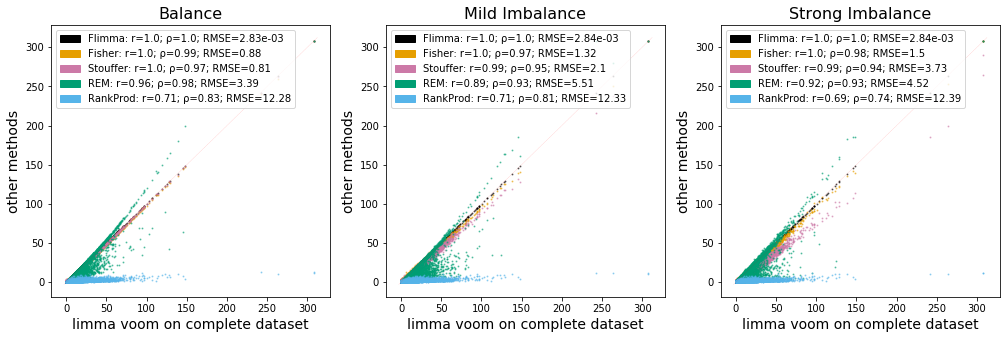

In [7]:
corrs = plt_results(dfs, text = "",colors = colors)
plt.savefig("../../paper_v1/Fig3B_Performace_GTEx.svg")
plt.savefig("../../paper_v1/Fig3B_Performace_GTEx.png")
corrs

In [8]:
stats = {}
stats2  = {}
for m in ["FP","FN","Precision","Recall","F1"]:
    for ds in ["Balance","Mild Imbalance","Strong Imbalance"]:
        df = dfs[ds].sort_values(by="pv_Rlimma",ascending = False)
        results = calc_stats(df,lfc_thr=1,adj_pval_thr = -np.log10(0.05),
                                                        methods=["Flimma","Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    #print(confusion_matrix)
pd.DataFrame.from_dict(stats)

FP                                      FN                 \
         Balance Mild Imbalance Strong Imbalance Balance Mild Imbalance   
Flimma       0.0            0.0              0.0     0.0            0.0   
Fisher       4.0           32.0             67.0     0.0           18.0   
Stouffer     4.0           32.0             67.0     0.0           18.0   
REM          4.0           15.0             21.0     2.0           14.0   
RankProd     4.0           32.0             67.0     0.0           18.0   

                          Precision                                    Recall  \
         Strong Imbalance   Balance Mild Imbalance Strong Imbalance   Balance   
Flimma                0.0  1.000000       1.000000         1.000000  1.000000   
Fisher               33.0  0.986063       0.891525         0.789969  1.000000   
Stouffer             33.0  0.986063       0.891525         0.789969  1.000000   
REM                  12.0  0.985965       0.946809         0.928571  0.992933   
RankProd             33.0  0.986063       0.891525         0.789969  1.000000   

                                                F1                 \
         Mild Imbalance Strong Imbalance   Balance Mild Imbalance   
Flimma         1.000000         1.000000  1.000000       1.000000   
Fisher         0.935943         0.884211  0.992982       0.913194   
Stouffer       0.935943         0.884211  0.992982       0.913194   
REM            0.950178         0.957895  0.989437       0.948490   
RankProd       0.935943         0.884211  0.992982       0.913194   

                           
         Strong Imbalance  
Flimma           1.000000  
Fisher           0.834437  
Stouffer         0.834437  
REM              0.943005  
RankProd         0.834437

In [9]:
stats2 = find_diff(dfs)
stats2 = stats2.loc[["Balance","Mild Imbalance","Strong Imbalance"],:]
stats2.style.format("{:.2e}")  

In [10]:
stats = {}
for m in ["RMSE","r","ρ"]:
    for ds in ["Balance","Mild Imbalance","Strong Imbalance"]:
        df = dfs[ds].sort_values(by="pv_Rlimma",ascending = False)
        results = calc_stats(df,lfc_thr=1,adj_pval_thr = -np.log10(0.05),
                                                        methods=["Flimma","Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    
    #print(confusion_matrix)
pd.DataFrame.from_dict(stats)

RMSE                                         r                 \
            Balance Mild Imbalance Strong Imbalance   Balance Mild Imbalance   
Flimma     0.002830       0.002836         0.002843  1.000000       1.000000   
Fisher     0.878869       1.322750         1.502504  0.999064       0.996628   
Stouffer   0.810353       2.096610         3.733528  0.999254       0.993574   
REM        3.389091       5.509953         4.524129  0.956151       0.887192   
RankProd  12.277266      12.328498        12.386662  0.713763       0.706568   

                                  ρ                                  
         Strong Imbalance   Balance Mild Imbalance Strong Imbalance  
Flimma           1.000000  1.000000       1.000000         1.000000  
Fisher           0.995652  0.985901       0.972334         0.975665  
Stouffer         0.987230  0.968612       0.952263         0.936901  
REM              0.921097  0.977563       0.932485         0.930350  
RankProd         0.689613  0.834402       0.805074         0.743951

### Fig 4B

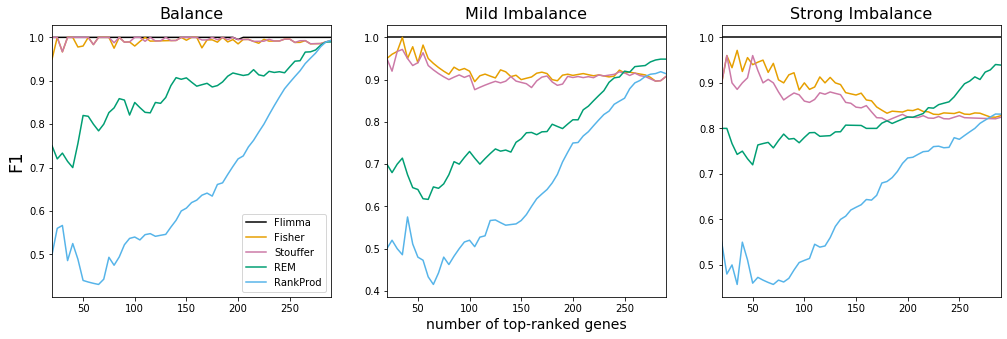

In [11]:
min_n_genes = 20
step = 5
max_n_genes = n_DE_genes+step

tmp = plot_stats_for_topN(dfs,metrics=["F1"],log=False,min_n_genes=min_n_genes,
                          max_n_genes = max_n_genes,step=step,text="",colors=colors,
                          figfile= "../../paper_v1/Fig4B_F1_GTEx.svg")

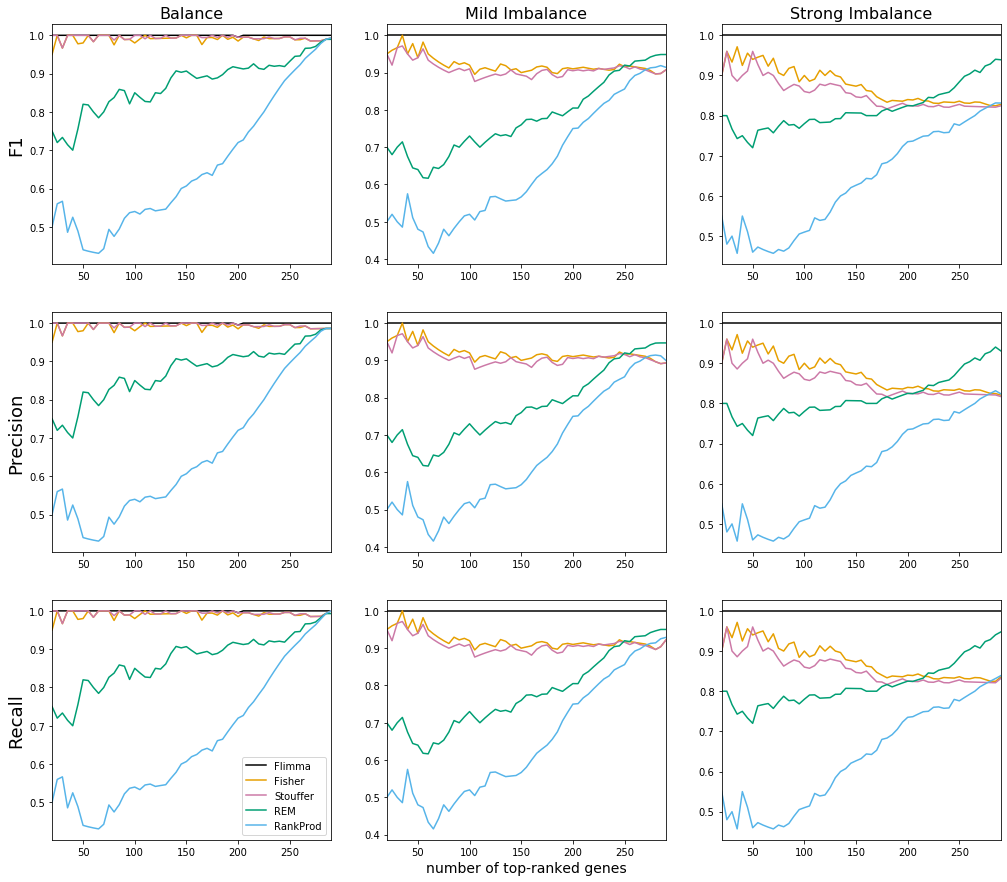

In [12]:
data = plot_stats_for_topN(dfs,metrics=["F1","Precision","Recall"],min_n_genes=min_n_genes,
                            max_n_genes = max_n_genes, step=step,colors=colors)

### correlation and RMSE

### Fig. S3

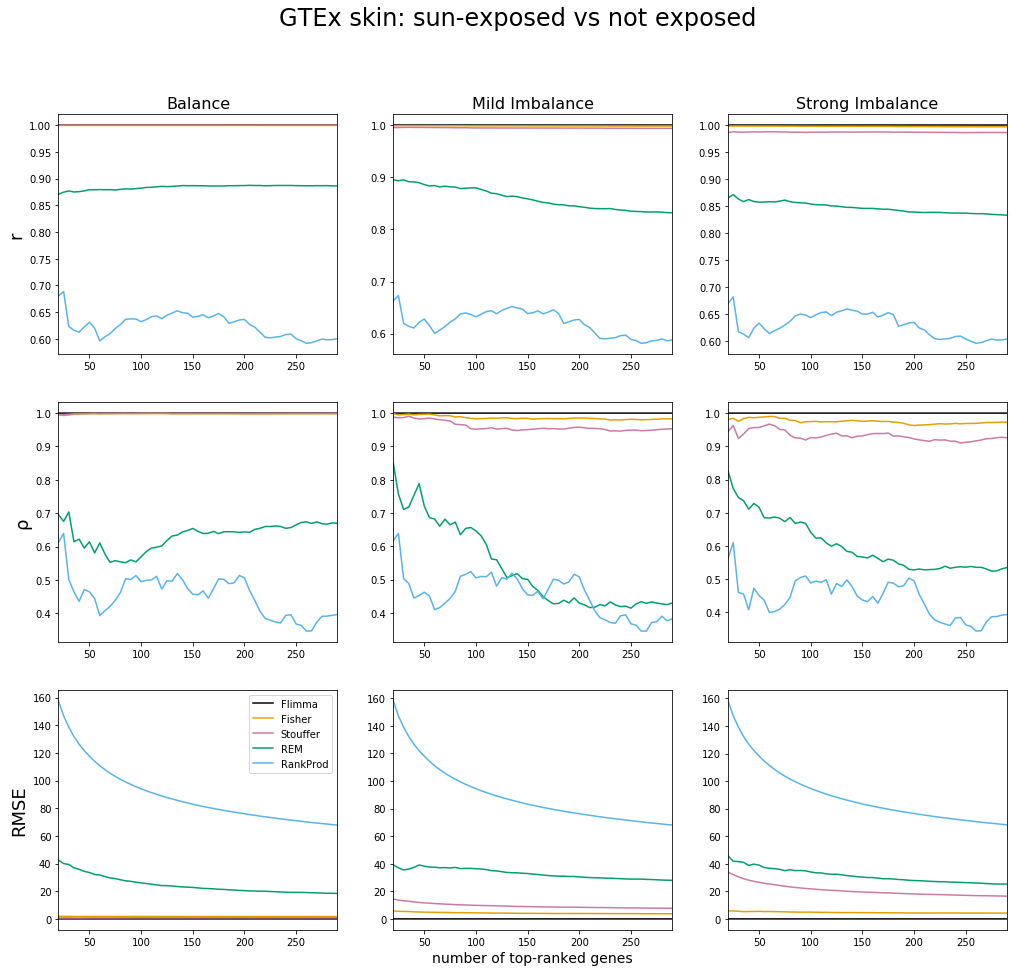

In [13]:
data = plot_stats_for_topN(dfs,metrics=["r","ρ","RMSE"],min_n_genes=min_n_genes,
                            max_n_genes = max_n_genes, step=step,colors=colors,
                            suptitle = "GTEx skin: sun-exposed vs not exposed",
                            figfile="../../paper_v1/Supplementary/FigS3_RMSE_corr_GTEx.png")